# Current-Based Spiking Neural Network (current-SNN)

The following code simulates a Coördinated Spiking Model with $\textit{N}$ neurons and a $\textit{d}$-dimensional input. The model contains the following functions:

- initialize_weights: initialize weights for the different neurons
- initialize_params_N: initialize the variables and parameters for simulating the network
- time_varying_signal: creates sinusoidal input signal with $\textit{d}$ dimensions
- run_N: runs the spiking network model
- plot_N: plots the results (input + input estimate, spike trains and voltages)

In addition, other functions have been added to plot the parameters of the network.

## Install required packages

Install required packages

In [133]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import random
import os
import matplotlib.animation as animation
import copy

Function used for plotting the spike trains

## Functions used for simulation

### Initialize weights

Initialize weights

In [13]:
def initialize_weights(N, d):
    """ Initialize decoding weights of the different neurons. """

    if d == 2:
        # 2-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)       
        D = np.zeros((N,d))
        D[:, 0] = [np.sin(weight) for weight in weights[0:N]]
        D[:, 1] = [np.cos(weight) for weight in weights[0:N]]
        
    else:
        D = np.random.normal(0, 0.4, size=(N, d)) 
               
    return D

### Initialize parameters

Initialize parameters

In [14]:
def initialize_params_N(N, d, iterations, dt, D, beta):
    """ Initialize variables and parameters. """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    x_est = np.zeros((d, iterations))

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = [(np.dot(weight, weight) + beta)/2 for weight in D]

    return (t, voltage, x_est, o, T)

### Time varying signal

Create time varying signal

In [121]:
def time_varying_signal():
    "Create time varying signal following a sinusoidal function. "
    
    c = []
    x = []
    
    # number of sinus periods (total # of sinus periods = 2 * cycles)
    cycles = 2
    t = np.linspace(0, np.pi, d + 1)       # starting points of d-dimensioan sinusoidal input signals
    
    for i in range(d):
        
        x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i])
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)

    c = np.asarray(c).reshape((d, iterations - 1))
    x = np.asarray(x).reshape((d, iterations))

    return(c, x)

### Run simulation

In [16]:
def run_N(tau, beta):
    """ Run simulation with time constant, tau, and constant for the cost, beta. """
    
    for t in range(1, iterations):
        
#         if d > 1:
        # input signal with dimensions > 1
            
        # update input estimate
        reset = np.zeros((1, d))
        for i in range(N):
            if o[i, t - 1] > 0:
                reset = np.dot(D[i, :], o[i, t - 1])
        dxestdt = (-1/tau) * x_est[:, t - 1] + reset
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt

        # update voltages
        reset = 0
        for i in range(N):
             if o[i, t - 1] > 0:
                    reset = np.dot(D, D[i, :]) * o[i, t - 1]
        dVdt = (-1/tau) * voltage[:, t - 1] + np.dot(D, c[:,t - 1]) - reset
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

### Visualize results

Functions used to visualize results

In [2]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

In [17]:
def plot_N(color, plot_voltage=1):
    """ Plots the results, including input and input estimate per dimension 
        as well as the spike trains and voltages of the individual neurons. """
    
    # determine number of plots
    if plot_voltage == 1:
        plot = d + N + 1
    else:
        plot = d + 1
    
    pl.subplots(plot, 1, figsize=(12, 16))
    pl.subplots_adjust(hspace=0.2 * N)
    counter = 1
    
    # enable LaTeX
    pl.rc('text', usetex=True)
       
    for i in range(1, d + 1):
        # input signal with more than 1 dimension
        pl.subplot(plot, 1, counter)
        pl.plot(x_est[i - 1,:], label=r'$\hat{x}_{%i}$' %i, color='gray')
        pl.plot(x[i - 1,:], label='$x_{%i}$' %i, color='k')
        pl.yticks([])
        pl.xticks([])
        pl.legend()
        counter = counter + 1
    
    # plot spike trains per neuron over time
    fig = pl.subplot(plot, 1, counter)
    
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='N%i' %i, s=1.5)
    
    pl.title('Spike train', fontsize=15)
    pl.yticks([])
    pl.xticks([])
    pl.xlim(0, iterations)
    pl.legend()
    
    counter = counter + 1
    
    if plot_voltage == 1: 
        # plot voltage per neuron over time
        for i in range(1, N + 1):
            pl.subplot(plot, 1, counter)
            pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='voltage')
            pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.xlim(0, iterations)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i,  fontsize=15)
            pl.legend()
            counter = counter + 1
        
    pl.xlabel('time')

## Other functions

### Decoding weights

In [125]:
def plot_weights():
    """ Plot the weights for N neurons (2D and 3D input signal). """
        
    if d == 2:
    # 2-dimensional input signal
        
        plots = 2
        pl.subplots(plots, 1) # figsize=(12, 4)
   
        # plot weights as arrows
        pl.subplot(1, 2, 1)
        pl.axis('square')
        for i in range(1, N + 1):
            arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
        pl.xlabel('D1')
        pl.ylabel('D2')
        pl.title('Weights')
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)

        # plot weights as points
        pl.subplot(1, 2, 2)
        pl.axis('square')
        for i in range(1, N + 1):
            pl.scatter(D[i - 1][0], D[i - 1][1], color=color[i - 1][:]/255, label='N%i' %i)
        pl.xlabel('D1')
        pl.ylabel('D2')
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)
        pl.title('Weights')
        #pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        pl.legend()
        
    elif d == 3:
    # 3-dimensional input signal
        
        fig = pl.figure()
        ax = pl.axes(projection='3d')
        
        # plot weights as points
        for i in range(1, N + 1):
            ax.scatter3D(D[i - 1][0], D[i - 1][1], D[i - 1][2], color=color[i - 1][:]/255, s=50, label='N%i' %i)
        ax.set_xlabel('D1')
        ax.set_ylabel('D2')
        ax.set_zlabel('D3')
        pl.title('Weights',fontsize=20)
        #pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        pl.legend()
    else:
        print("No plot generated: function for 2D and 3D signal input only. ")

### Bounding Box

In [115]:
def plot_bounding_box():
    """ Plot bounding box. """
    
    fig = pl.figure()
    pl.axis('square')
    pl.title('Error space plot', fontsize=15)
    x1 = np.linspace(-10, 10, 2)
    x2 = np.zeros(2)
    for i in range(1, N + 1):
        for j in range(2):
            x2[j] = (T[i - 1] - x1[j] * D[i - 1, 0]) / D[i - 1, 1]
        pl.plot(x1, x2, label="N%i" %i, color=color[i - 1]/255)
    pl.yticks([])
    pl.xticks([])
    pl.xlim(-1.5, 1.5)
    pl.ylim(-1.5, 1.5)
    pl.xlabel('$x_{1} - \hat{x}_{1}$', fontsize=20)
    pl.ylabel('$x_{2} - \hat{x}_{2}$', fontsize=20)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
    
    return fig

In [124]:
def bounding_box_animation_2D(frames=iterations, interval=70):

    # file
    file = 'C:/Users/amber/MachensLab/BoundingBox/D' + str(d) + '_N' + str(N) + '.gif'

    # initiate plot
    fig = plot_bounding_box()
    point, = pl.plot([], [], 'k', lw=3)
    
    # compute representation error over time
    start = 400
    error = x[:, start:iterations] - x_est[:, start:iterations]
    error_x1 = error[0, :]
    error_x2 = error[1, :]
    
    def animate(i):
        x = error_x1[i - 3:i]
        y = error_x2[i - 3:i]
        point.set_data(x, y)
        return point,

    # runs animation
    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
    ani.save(file, writer='imagemagick') # save as .gif
    pl.show()
    
    return fig

In [140]:
def plot_error_space(arrow=0, error=0):
    """ Plots 2D error space with the bounding box. """
    
    if d == 2:
    # check for 2-dimensional input signal
    
        # enable LaTeX
        pl.rc('text', usetex=True)
        
        # plot bounding box
        fig = plot_bounding_box()

        # plot signal representtation error over time (if error = 1)
        if error == 1:
            start = 200
            error = x[:, :] - x_est[:, :]
            pl.plot(error[0], error[1], 'k', alpha = 0.2)
            
    else:
        print("2D signal input only. ")

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [129]:
def exponential_filter(t, tau):
    """ Exponential filter. """
    return np.exp(-t/tau)

In [130]:
def firing_rate(spike_train, filt):
    """ Compute firing rate by the convolution of exponential filter and spike train. """
    return np.convolve(spike_train, filt)

Compute and plot firing rate per neuron

In [131]:
def visualize_firing_rate():
    """ Compute and visualize firing rate of each neuron. """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 100] = 1

    # initialize exponential filter
    tau = 1.5
    y = [exponential_filter(i, tau) for i in t]

    # initialize plots
    plots = N
    pl.subplots(plots, 1)
    pl.suptitle('Firing rate', fontsize=15)
    counter = 1

    # compute input estimate 
    for i in range(1, N+1):

        # compute firing rate
        firingrate = firing_rate(spike_trains[i - 1, :], y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        counter = counter + 1
        pl.plot(firingrate[0: iterations], color=color[i - 1][:]/255, label='N%i' %i)
        pl.ylim(0, max(firingrate) + 0.5)
        pl.legend()

## Run simulation

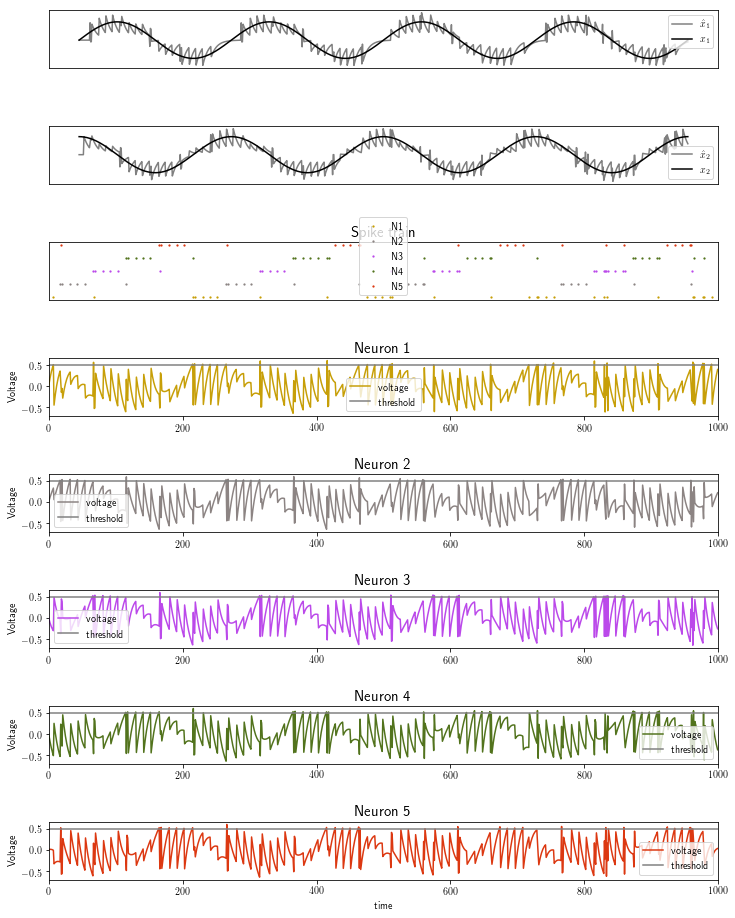

In [156]:
# Run simulation and plot results for given parameters
N = 5                                                    # number of neurons
d = 2                                                    # number of dimensions of signal input
iterations = 1000                                        # number of time steps
dt = 0.1                                                # step size
tau = 1                                                  # time constant
beta = 0.0                                               # cost 
color = np.random.randint(0, 255, size=(N, 3))           # color map for plotting the different neurons

# run simulation
D = initialize_weights(N, d)                                                # initialize decoding weights
t, voltage, x_est, o, T = initialize_params_N(N, d, iterations, dt, D, beta)# initialize parameters
c, x = time_varying_signal()                                                # create d-dimensional input signal
run_N(tau, beta)                                                            # run spiking network
plot_N(color, plot_voltage=1)                                               # plot results

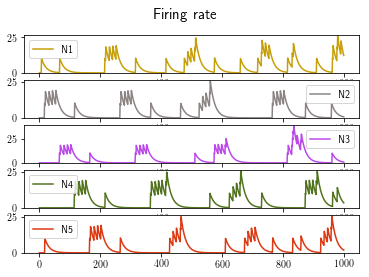

In [157]:
visualize_firing_rate()

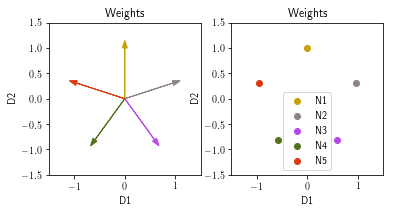

In [158]:
plot_weights()

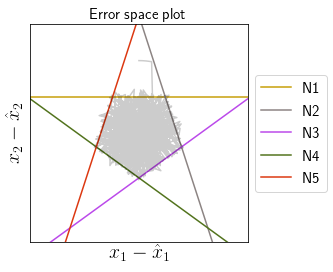

In [159]:
plot_error_space(error=1)

MovieWriter imagemagick unavailable. Trying to use pillow instead.


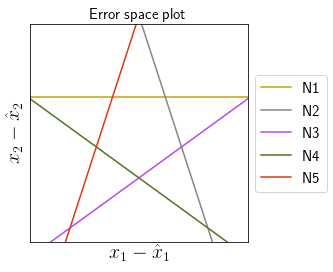

In [161]:
fig = bounding_box_animation_2D()